In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from tensorflow.keras import backend
from keras import backend as K
import tensorflow as tf
import random
import collections
from keras.layers import Dropout
from keras.models import Sequential 
from keras.layers import Dense 
from pathlib import Path
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from six import StringIO
from copy import copy
from scipy import stats
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def encodeWithBLOSUM62(amino_acids):
    ## a function that returns the blosum62 vector given a certain aa 
    return list(BLOSUM62_MATRIX[amino_acids].values)

def blosumEncoding(data):
    ## a function that creates amino acid sequence that encode by blosum62 matrix 
    total_data_row =[]
    for each in data:
    
        eachrow =[]
        for aa in each:
            eachrow = eachrow+ encodeWithBLOSUM62(aa)
    
        total_data_row.append(eachrow)
    
    return pd.DataFrame(total_data_row)

def split(word): 
    return [char for char in word] 

COMMON_AMINO_ACIDS = collections.OrderedDict(sorted({
   "A": "Alanine",
   "R": "Arginine",
   "N": "Asparagine",
   "D": "Aspartic Acid",
   "C": "Cysteine",
   "E": "Glutamic Acid",
   "Q": "Glutamine",
   "G": "Glycine",
   "H": "Histidine",
   "I": "Isoleucine",
   "L": "Leucine",
   "K": "Lysine",
   "M": "Methionine",
   "F": "Phenylalanine",
   "P": "Proline",
   "S": "Serine",
   "T": "Threonine",
   "W": "Tryptophan",
   "Y": "Tyrosine",
   "V": "Valine",
   }.items()))
COMMON_AMINO_ACIDS_WITH_UNKNOWN = copy(COMMON_AMINO_ACIDS)
COMMON_AMINO_ACIDS_WITH_UNKNOWN["X"] = "Unknown"
   
AMINO_ACID_INDEX = dict((letter, i) for (i, letter) in enumerate(COMMON_AMINO_ACIDS_WITH_UNKNOWN))

AMINO_ACIDS = list(COMMON_AMINO_ACIDS_WITH_UNKNOWN.keys())
   
BLOSUM62_MATRIX = pd.read_csv(StringIO("""
  A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  X
   A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0  0
   R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3  0
   N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  0
   D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  0
   C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1  0
   Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0
   E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  0
   G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3  0
   H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0
   I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3  0
   L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1  0
   K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0
   M -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1  0
   F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1  0
   P -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2  0
   S  1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0
   T  0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0  0 
   W -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3  0
   Y -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1  0
   V  0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4  0
   X  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   """), sep='\s+').loc[AMINO_ACIDS, AMINO_ACIDS].astype("int8")
assert (BLOSUM62_MATRIX == BLOSUM62_MATRIX.T).all().all() 



Using TensorFlow backend.


In [64]:
def makeSameLength(each_peptide):
    first = each_peptide
    middle = each_peptide.center(15,"X")
    end = ''
    
    while len(first) < 15:
        first +='X'
        end+='X' 
    end = end + each_peptide[-len(each_peptide):]
    return first+middle+end

In [70]:
## Data preprocessing, importing the dataset
## need to change the file location
workdir = Path('G:\\MAC_Research_Data\\UGA\\3Fall\\DataMining6380\\Final_project')
               #'/Volumes/Research/MAC_Research_Data/UGA/3Fall/DataMining6380/Mini_projecct_2/')
dataset = pd.read_csv(workdir/"HLA-A-01_full_length.txt",sep='\t')

peptides = dataset.peptide.values
final_peptide = [split(makeSameLength(each_peptide)) for each_peptide in peptides]

In [71]:
## encode y label
from sklearn import preprocessing
y = dataset.Binder.values
le = preprocessing.LabelEncoder()
a = le.fit(y)
y= le.transform(y)

## encode x label using bl62 matrix
X = blosumEncoding(final_peptide).values
## to see the dataset distribution 
dataset.groupby('Binder').size()
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
val_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True,stratify = y)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=val_size, random_state = 0, shuffle=True)


In [77]:
## Create an ANN model
# Training the model
# Dense object will take care to initialize the random number close to 0 ( first ANN step)
classifier = Sequential() # use the sequential layer
classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,   kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
## here is the output layer
## if we deal with more than 2 categories, the activation function needs to use softmax
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
opt = keras.optimizers.rmsprop(learning_rate= 0.001)
# Compiling the ANN
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience= 50)
# check the model performance and save the best model
mc = ModelCheckpoint(
    'G:/MAC_Research_Data/UGA/3Fall/DataMining6380/Final_project/Final_best_50_batch_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    #'/Volumes/Research/MAC_Research_Data/UGA/3Fall/DataMining6380/Mini_projecct_2/Minproject2best_50batch_model.h5', monitor='val_loss', mode='min', save_best_only=True)

classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                75680     
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 81        
Total params: 88,721
Trainable params: 88,721
Non-trainable params: 0
__________________________________________________

Epoch 00070: early stopping


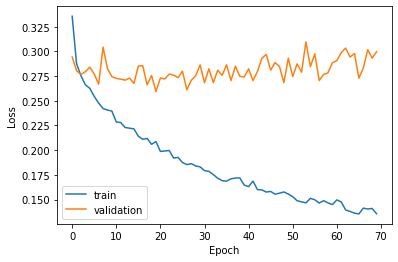

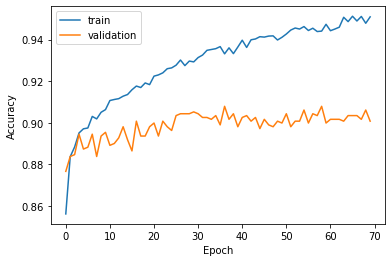

	True	False
True	1644	131
Flase	106	917
--------------------
accuracy: 0.9152966404574696
	True	False
True	1609	166
Flase	79	944
--------------------
accuracy: 0.9124374553252323
	True	False
True	1533	242
Flase	55	968
--------------------
accuracy: 0.8938527519656898
0.9152966141700745


In [78]:
history = classifier.fit(X_train, y_train, validation_data= (X_val,y_val), verbose =0, batch_size = 50, epochs = 200, callbacks = [mc,es])

# the plot to see the lose function during the training process in training dataset and validation dataset

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.savefig('/Volumes/Research/MAC_Research_Data/UGA/3Fall/DataMining6380/Mini_projecct_2/training_accuracy.png',dpi=100, bbox_inches='tight')
plt.show()

# Predicting the Test set results
y_pred = classifier.predict(X_test)

## the output give the probability and we apply the cut off to decide if the peptide is a binder or not
# Here I just want to know if we apply different cutoff, would it create different results?
thresheld = [0.5,0.7,0.9]
y_pred_list =[]
for i in thresheld:
    y_pred_value = (y_pred > i).tolist()
    y_pred_list.append(y_pred_value)
    
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
cm_list=[]
for i in range(len(y_pred_list)):
    cm = confusion_matrix(y_test, y_pred_list[i],labels=[1,0])
    cm_list.append(cm)
    print("","True","False",sep="\t")
    print("True",cm[0,0],cm[0,1],sep="\t" )
    print("Flase",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    print("accuracy:", metrics.accuracy_score(y_pred_list[i],y_test))   


test_loss, test_acc = classifier.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

In [79]:
## balance the class and create a new dataframe
from sklearn.utils import resample
Binder_max_count = dataset.groupby(['Binder']).count().max()[0]
Binders = dataset.Binder.unique()
Binders = np.delete(Binders, np.where(Binders == False), axis =0 )
df_majority = dataset[dataset.Binder==False]
for binder in Binders: 
    df_minority_upsampled = resample(dataset[dataset['Binder']==binder], 
                                 replace=True,     # sample with replacement
                                 n_samples=Binder_max_count,    # to match majority class
                                 random_state=42) # reproducible results
    
    df_majority = pd.concat([df_majority, df_minority_upsampled])

In [82]:
## Test if balance the class can improve the accuracy
peptides = df_majority.peptide.values
final_peptide = [split(makeSameLength(each_peptide)) for each_peptide in peptides]

y = df_majority.Binder.values
le = preprocessing.LabelEncoder()
a = le.fit(y)
y= le.transform(y)

## encode x label using bl62 matrix
X = blosumEncoding(final_peptide).values
## to see the df_majority distribution 
df_majority.groupby('Binder').size()
# Splitting the df_majority into the Training set and Test set
from sklearn.model_selection import train_test_split 
val_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True,stratify = y)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=val_size, random_state = 0, shuffle=True)
## Create an ANN model
# Training the model
# Dense object will take care to initialize the random number close to 0 ( first ANN step)
classifier = Sequential() # use the sequential layer
classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
classifier.add(Dropout(rate = 0.5))
classifier.add(Dense(units = 80,   kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
## here is the output layer
## if we deal with more than 2 categories, the activation function needs to use softmax
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
opt = keras.optimizers.rmsprop(learning_rate= 0.001)
# Compiling the ANN
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience= 50)
# check the model performance and save the best model
mc = ModelCheckpoint('G:/MAC_Research_Data/UGA/3Fall/DataMining6380/Final_project/Final_best_balanced_50_batch_model.h5', 
                     monitor='val_loss', mode='min', save_best_only=True)

classifier.summary()

history = classifier.fit(X_train, y_train, validation_data= (X_val,y_val), batch_size = 50, epochs = 200, callbacks = [mc,es])

# the plot to see the lose function during the training process in training df_majority and validation df_majority

# Predicting the Test set results
y_pred = classifier.predict(X_test)

## the output give the probability and we apply the cut off to decide if the peptide is a binder or not
# Here I just want to know if we apply different cutoff, would it create different results?
thresheld = [0.5,0.7,0.9]
y_pred_list =[]
for i in thresheld:
    y_pred_value = (y_pred > i).tolist()
    y_pred_list.append(y_pred_value)
    
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
cm_list=[]
for i in range(len(y_pred_list)):
    cm = confusion_matrix(y_test, y_pred_list[i],labels=[1,0])
    cm_list.append(cm)
    print("","True","False",sep="\t")
    print("True",cm[0,0],cm[0,1],sep="\t" )
    print("Flase",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    print("accuracy:", metrics.accuracy_score(y_pred_list[i],y_test))   


test_loss, test_acc = classifier.evaluate(X_test,  y_test, verbose=2)
print(test_acc)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 80)                75680     
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 80)                6480      
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 81        
Total params: 88,721
Trainable params: 88,721
Non-trainable params: 0
__________________________________________________

10071/10071 [==============================] - 1s 71us/step - loss: 0.1300 - accuracy: 0.9524 - val_loss: 0.2679 - val_accuracy: 0.9205
Epoch 49/200
10071/10071 [==============================] - 1s 74us/step - loss: 0.1304 - accuracy: 0.9540 - val_loss: 0.2650 - val_accuracy: 0.9151
Epoch 50/200
10071/10071 [==============================] - 1s 78us/step - loss: 0.1291 - accuracy: 0.9543 - val_loss: 0.2598 - val_accuracy: 0.9187
Epoch 51/200
10071/10071 [==============================] - 1s 69us/step - loss: 0.1301 - accuracy: 0.9540 - val_loss: 0.2561 - val_accuracy: 0.9223
Epoch 52/200
10071/10071 [==============================] - 1s 72us/step - loss: 0.1297 - accuracy: 0.9527 - val_loss: 0.2655 - val_accuracy: 0.9169
Epoch 53/200
10071/10071 [==============================] - 1s 74us/step - loss: 0.1262 - accuracy: 0.9542 - val_loss: 0.2845 - val_accuracy: 0.9124
Epoch 54/200
10071/10071 [==============================] - 1s 76us/step - loss: 0.1320 - accuracy: 0.9527 - val_loss: 

In [94]:
## Stratified Kfold with Keras
## if your computer is not mac, the n_jobs = 1 or you

def build_classifier():
    classifier = Sequential() # use the sequential layer
    ## init = kernel_initializer
    classifier.add(Dense(units = 80, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
    classifier.add(Dropout(p = 0.5))
    classifier.add(Dense(units = 80,  kernel_initializer = 'uniform', activation = 'tanh', input_dim = 945))
    ## if we deal with more than 2 categories, the activation function needs to use softmax
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    opt = keras.optimizers.rmsprop(learning_rate= 0.001)
    # Compiling the ANN
    classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 50, epochs = 200)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = kfold, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

# Build Classifiers and Statistical analysis
## Corey

In [78]:
# Three classifieres 
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

clf_rf = RandomForestClassifier(n_estimators=100, random_state=18, max_features = 'sqrt',n_jobs=-1, verbose = 0)
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
print('Random Forest Accuracy: ' + str(metrics.accuracy_score(y_test,y_pred)))

# Decision Tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
print('Decision Tree Accuracy: ' + str(metrics.accuracy_score(y_test,y_pred)))

#Gaussian Native Bayes
clf_nb = GaussianNB()
clf_nb.fit(X_train,y_train)
y_pred = clf_nb.predict(X_test)
print('Gaussian NB Accuracy: ' + str(metrics.accuracy_score(y_test,y_pred)))

Random Forest Accuracy: 0.8984635938543755
Decision Tree Accuracy: 0.8443553774215097
Gaussian NB Accuracy: 0.8189712758851035


In [79]:
# K fold cross validation decision Tree
from sklearn.model_selection import StratifiedKFold
from sklearn import tree 

treescores = []
clf_dt = DecisionTreeClassifier()
k_fold = StratifiedKFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X,y):
    clf_dt.fit(X[train_indices], y[train_indices]) 
    predicted_dt = clf_dt.predict(X[test_indices])
    treescores.append(metrics.accuracy_score(y[test_indices], predicted_dt))
    
for i in treescores:
    print("each fold accuracy:", i)

each fold accuracy: 0.7770360480640854
each fold accuracy: 0.6795727636849133
each fold accuracy: 0.4512683578104139
each fold accuracy: 0.5874499332443258
each fold accuracy: 0.8101604278074866
each fold accuracy: 0.6016042780748663
each fold accuracy: 0.7366310160427807
each fold accuracy: 0.5922459893048129
each fold accuracy: 0.5106951871657754
each fold accuracy: 0.7272727272727273


In [14]:
# K fold cross validation Native Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
naive_bayes_scores = []
clf_nb = GaussianNB()
k_fold = StratifiedKFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X,y):
    clf_nb.fit(X[train_indices], y[train_indices]);
    predicted_nb = clf_nb.predict(X[test_indices]);
    naive_bayes_scores.append(metrics.accuracy_score(y[test_indices], predicted_nb))
    
for i in naive_bayes_scores:
    print("each fold accuracy:", i)


each fold accuracy: 0.8491321762349799
each fold accuracy: 0.8184245660881175
each fold accuracy: 0.8571428571428571
each fold accuracy: 0.8090787716955942
each fold accuracy: 0.8048128342245989
each fold accuracy: 0.7927807486631016
each fold accuracy: 0.8275401069518716
each fold accuracy: 0.8074866310160428
each fold accuracy: 0.786096256684492
each fold accuracy: 0.767379679144385


In [76]:
# T test 
# corrected resampled t-statistic (assumes we use repeated train/test splits or repeated cross-validation). 
import math

from scipy.stats import norm,t, binom
dist = norm(0,1)

diff = scores[:,0]-scores[:,1]
k = len(diff)
variance = np.var(diff,ddof=1)
foldcount = 10;
test_size = math.floor(data1.shape[0]/foldcount);
train_size = math.floor(data1.shape[0]-test_size);
tval = np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))
pval = dist.cdf(tval)*2
print("Corrected Resampled t-statistic:")
print("\nt-value {}, p-value {}".format(tval, pval))

# NB vs NN

Corrected Resampled t-statistic:

t-value -8.295357043288218, p-value 1.0825954695534295e-16


In [134]:
# Kappa scores 
from sklearn.metrics import cohen_kappa_score
print("Unscaled Kappa - Decision Tree: " + str(cohen_kappa_score(y[test_indices], predicted_dt)))
print("Unscaled Kappa - GaussianNB: " + str(cohen_kappa_score(y[test_indices], predicted_nb)))
print("Unscaled Kappa - ANN: " + str(cohen_kappa_score(y_test, le.transform(y_pred_list[0]))))

Unscaled Kappa - Decision Tree: 0.45976718497748326
Unscaled Kappa - GaussianNB: 0.5364825208695404
Unscaled Kappa - ANN: 0.7480694374828867


In [ ]:
# T test NB vs DT

diff = scores[:,2]-scores[:,0]

dist = norm(0,1)
k = len(diff)
variance = np.var(diff,ddof=1)
foldcount = 10;
test_size = math.floor(data1.shape[0]/foldcount);
train_size = math.floor(data1.shape[0]-test_size);
tval = np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))
pval = dist.cdf(tval)*2
print("Corrected Resampled t-statistic:")
print("\nt-value {}, p-value {}".format(tval, pval))

In [ ]:
# T test NN vs DT

diff = scores[:,2]-scores[:,1]

dist = norm(0,1)
k = len(diff)
variance = np.var(diff,ddof=1)
foldcount = 10;
test_size = math.floor(data1.shape[0]/foldcount);
train_size = math.floor(data1.shape[0]-test_size);
tval = np.mean(diff)/math.sqrt(variance*(1/k+ test_size/train_size))
pval = dist.cdf(tval)*2
print("Corrected Resampled t-statistic:")
print("\nt-value {}, p-value {}".format(tval, pval))

In [ ]:
# Feature Importance
# make figure of top 10 features, importances - Decision Tree had best accuracy

model = DecisionTreeClassifier()
model.fit(X,y)
importance = model.feature_importances_
visualize
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

## Model Evaluation
### Kivanc

In [ ]:
## Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    source: http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

In [ ]:
## Compute and plot the confusion matrix for the ANN model
cm_ANN = confusion_matrix(y_test, y_pred.round(), labels=[1, 0])
print(cm_ANN)
plt.figure(figsize=(10,8))
plot_confusion_matrix(cm_ANN, classes=[1, 0],
                      title='Confusion Matrix, ANN')
plt.savefig('fig1.png')

In [ ]:
## Compute and plot the classification metrics for the ANN model

from sklearn.metrics import classification_report
import seaborn as sns

report_ANN = classification_report(y_test, y_pred.round(), output_dict=True)
report_ANN = pd.DataFrame(report_ANN).transpose()
report_ANN.to_csv ("//Users/kivanc/DataMining-ML/Projects/MiniProject2/report_ANN.csv", index = True, header=True)

plt.figure(figsize=(10,8))
fig_class = sns.heatmap(pd.DataFrame(report_ANN).iloc[:, :-1], annot=True, cmap="YlGnBu", fmt=".4g")
plt.title("Classification Metrics, ANN", fontweight='bold')
plt.xlabel('Metrics', fontweight='bold') # x-axis label with fontsize 15
plt.ylabel('Classes', fontweight='bold') # y-axis label with fontsize 15
plt.yticks(rotation=0)
plt.savefig('fig2.png')

In [ ]:
## Compute and plot the classification metrics for the ANN model

from sklearn.metrics import classification_report
import seaborn as sns

report_ANN = classification_report(y_test, y_pred.round(), output_dict=True)
report_ANN = pd.DataFrame(report_ANN).transpose()
report_ANN.to_csv ("//Users/kivanc/DataMining-ML/Projects/MiniProject2/report_ANN.csv", index = True, header=True)

plt.figure(figsize=(10,8))
fig_class = sns.heatmap(pd.DataFrame(report_ANN).iloc[:, :-1], annot=True, cmap="YlGnBu", fmt=".4g")
plt.title("Classification Metrics, ANN", fontweight='bold')
plt.xlabel('Metrics', fontweight='bold') # x-axis label with fontsize 15
plt.ylabel('Classes', fontweight='bold') # y-axis label with fontsize 15
plt.yticks(rotation=0)
plt.savefig('fig2.png')

In [ ]:
def make_ROC(data_actual, data_predict):
    """
    Function to compute ROC. Takes two
    parameters: first is actual scores,
    and second is predicted scores.
    """
    N=len(data_actual)

    TPF=[]
    FPF=[]
    threshold=0
    j=0
    increment=1/N

    while(threshold<=1.1):
        #threshold=i
        TP, FP, TN, FN = 0, 0, 0, 0
        # Accumulate the true/false negative/positives
        for j in range(N):
            if data_actual[j]==1:
                if data_predict[j]>=threshold:
                    TP+=1
                else:
                    FN+=1
            if data_actual[j]==0:
                if data_predict[j]>=threshold:
                    FP+=1
                else:
                    TN+=1

        # Calcualate true positive rate for current threshold.           
        TP_Rate=TP/(TP + FN)

        # Calcualate false positive rate for current threshold. 
        FP_Rate=FP/(FP + TN)

        TPF.append(TP_Rate)
        FPF.append(FP_Rate)

        threshold+=increment

    return TPF, FPF

def plot_ROC(data_actual, data_predict):
    """
    Function to make ROC curve plot. Takes false
    positive rate and true positive rates list as
    parameters.
    """
    # Get True Positive Rate and False Positive Rate lists
    TPF, FPF = make_ROC(data_actual, data_predict)
    auc = -1 * np.trapz(TPF, FPF)
    # Plot the ROC curve
    fig = plt.figure(figsize=(10,8))
    plt.title('ROC Curve')
    plt.plot(FPF, TPF, marker='.', label='ROC Curve')
    plt.plot([0, 1], ls="--", label='Random Classifier')
    plt.title('ROC Curve, ANN (AUC = %.2f)'%auc, fontweight='bold')
    plt.xlabel('False Positive Rate (FPR)', fontweight='bold')
    plt.ylabel('True Positive Rate (TPR)', fontweight='bold')
    plt.legend()
    plt.show()